# Image Classification and Localization
In this lab, you'll build a CNN from scratch to:
- classify the main subject in an image
- localize it by drawing bounding boxes around it.

You'll use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset to synthesize a custom dataset for the task:
- Place each "digit" image on a black canvas of width 75 x 75 at random locations.
- Calculate the corresponding bounding boxes for those "digits".

The bounding box prediction can be modelled as a "regression" task, which means that the model will predict a numeric value (as opposed to a category).

## Import the necessary modules


In [13]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds


In [14]:
#Utilities for plotting bounding boxes

im_width = 75
im_height =75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness = 1, 
                                       display_str_list=()):
  image_pil = PIL.Image.fromarray(image)
  rbgimg = PIL.Image.new('RGBA', image_pil.size)
  rbgimg.paste(image_pil)
  draw_bounding_boxes_on_image(rbgimg, boxes, color, thickness, display_str_list)
  return np.array(rbgimg)

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  


In [15]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])
    
    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])
    
    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')

    
    
    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

# Select a Strategy

In [16]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices('GPU')

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU', tpu.cluster_spec().as_dict()['worker'])

elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.89.254.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.254.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU ['10.89.254.10:8470']
Number of accelerators:  8


In [17]:
# Instantiate the batch size
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [18]:
## Loading and Preprocessing the Dataset
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
   
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])
  
'''
Loads and maps the training split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''
def get_training_dataset():
      
      with  strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
      return dataset

'''
Loads and maps the validation split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''  
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

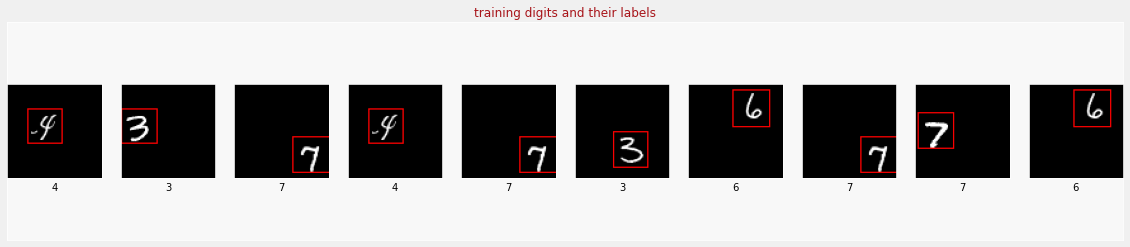

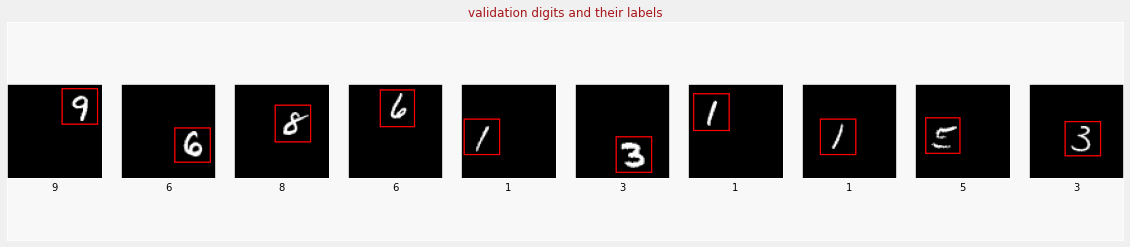

In [19]:
# visualize some images
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")

# Modelling

In [20]:
def feature_extractor(inputs):
  x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75,75,1))(inputs)
  x = tf.keras.layers.MaxPool2D((2,2))(x)
  x = tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3, input_shape=(75,75,1))(inputs)
  x = tf.keras.layers.MaxPool2D((2,2))(x)
  x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, input_shape=(75,75,1))(inputs)
  x = tf.keras.layers.MaxPool2D((2,2))(x)

  return x

def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x

def classifier(inputs):
  classification_output = tf.keras.layers.Dense(10, 
                                                'softmax',
                                                name='classification')(inputs)

  return classification_output

def bounding_box_regression(inputs):
  bounding_box_regression_output = tf.keras.layers.Dense(units=4, 
                                                         name='bounding_box')(inputs)

  return bounding_box_regression_output

def final_model(inputs):
  feature_cnn = feature_extractor(inputs)
  dense_output = dense_layers(feature_cnn)
  classification_output = classifier(dense_output)
  bounding_box_output = bounding_box_regression(dense_output)

  model = tf.keras.Model(inputs = inputs, 
                         outputs = [classification_output, bounding_box_output])

  return model

def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(optimizer = 'adam',
                loss = {'classification': 'categorical_crossentropy',
                        'bounding_box':'mse'},
                metrics = {'classification':'accuracy',
                           'bounding_box':'mse'})
  
  return model

with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75,75,1))
  model = define_and_compile_model(inputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 73, 73, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 36, 36, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 82944)        0           max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [21]:
# Train model
EPOCHS = 10
steps_per_epoch = 60000// BATCH_SIZE
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch = steps_per_epoch,
                    validation_data = validation_dataset,
                    validation_steps = validation_steps,
                    epochs = EPOCHS)

Epoch 1/10
117/117 [==============================] - 11s 41ms/step - loss: 1.8293 - classification_loss: 1.8063 - bounding_box_loss: 0.0230 - classification_accuracy: 0.3517 - bounding_box_mse: 0.0230 - val_loss: 1.2752 - val_classification_loss: 1.2510 - val_bounding_box_loss: 0.0241 - val_classification_accuracy: 0.5620 - val_bounding_box_mse: 0.0241
Epoch 2/10
117/117 [==============================] - 4s 33ms/step - loss: 1.0475 - classification_loss: 1.0186 - bounding_box_loss: 0.0289 - classification_accuracy: 0.6614 - bounding_box_mse: 0.0289 - val_loss: 0.8139 - val_classification_loss: 0.7835 - val_bounding_box_loss: 0.0304 - val_classification_accuracy: 0.7429 - val_bounding_box_mse: 0.0304
Epoch 3/10
117/117 [==============================] - 4s 32ms/step - loss: 0.7151 - classification_loss: 0.6871 - bounding_box_loss: 0.0279 - classification_accuracy: 0.7833 - bounding_box_mse: 0.0279 - val_loss: 0.5832 - val_classification_loss: 0.5599 - val_bounding_box_loss: 0.0233 - v

In [22]:
loss, c_loss, bb_loss, c_accuracy, bb_mse = model.evaluate(validation_dataset, steps=1)

1/1 [==============================] - 1s 1s/step - loss: 0.2822 - classification_loss: 0.2772 - bounding_box_loss: 0.0050 - classification_accuracy: 0.9144 - bounding_box_mse: 0.0050


**Calculate IOU**

In [23]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

Number of predictions where iou > threshold(0.6): 3832
Number of predictions where iou < threshold(0.6): 6168


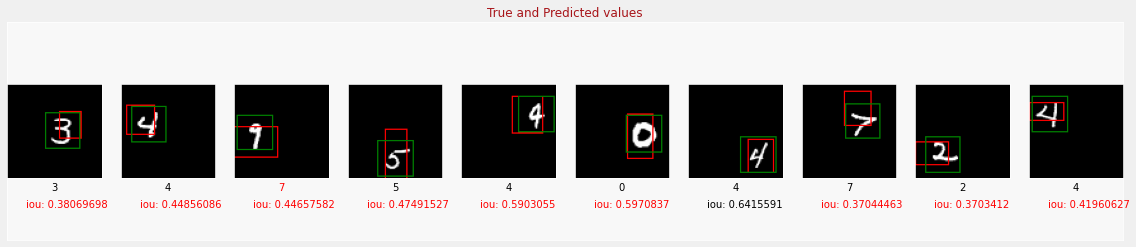

In [24]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")